In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
import glob
import functools
import operator

In [2]:
def foldl(func, acc, xs):
  return functools.reduce(func, xs, acc)

foldr = lambda func, acc, xs: functools.reduce(lambda x, y: func(y, x), xs[::-1], acc)

## Import LA results

In [3]:
def get_state_runs(state, seats, iters=100000, pop_bal=2.0, min_col="nWVAP",
                   ls=[2,5,10,20,40,80], ps=[0.25, 0.125, 0.0625]):
    results = {}

    for l in ls:
        sb_runs = glob.glob("data/states/{}_dists{}_{}opt_{}%_100000_sbl{}_score0_*.npy".format(state, seats, 
                                                                                                min_col, pop_bal, l))
        results[str(l)] = np.zeros((len(sb_runs), iters))
        for i, run in enumerate(sb_runs):
            results[str(l)][i] = np.load(run).flatten()
    for p in ps:
        tilt_runs = glob.glob("data/states/{}_dists{}_{}opt_{}%_100000_p{}_*.npy".format(state, seats, 
                                                                                         min_col, pop_bal, p))
        results[str(p)] = np.zeros((len(tilt_runs), iters))
        for i, run in enumerate(tilt_runs):
            results[str(p)][i] = np.load(run).flatten()
    return results

In [226]:
def create_state_df(runs, iters=100000):
    df_st = pd.DataFrame()
    for l in runs.keys():
        for i in range(runs[l].shape[0]):
            df = pd.DataFrame()
            df["Step"] = np.arange(iters)
            df["Maximum"] = np.maximum.accumulate(runs[l][i].flatten())
            df["run-type"] = "Short Burst" if float(l) > 1 else "Biased Run" if float(l) < 1 else "Unbiased Run"
            df["param"] = "b = {}".format(l) if float(l) > 1 else "q = {}".format(l)
            df_st = df_st.append(df, ignore_index=True)
    return df_st

In [5]:
la_runs_bvap = get_state_runs("LA", 105, ls=[2,5,10,25,50,100,200], 
                              pop_bal=4.5, min_col="BVAP")
la_runs_hvap = get_state_runs("LA", 105, ls=[2,5,10,25,50,100,200],
                              pop_bal=4.5, min_col="HVAP")
la_runs_nwvap = get_state_runs("LA", 105, ls=[2,5,10,25,50,100,200],
                               pop_bal=4.5, min_col="nWVAP")

In [227]:
ubs = glob.glob("data/unbiased_LA/LA_dists105_4.5%_100000_unbiased_*.p")
ub_runs = {}
for i, run in enumerate(ubs):
     with open(run, "rb") as f:
        ub_runs[i] = pickle.load(f)

In [228]:
runs = list(ub_runs.values())
bvap = foldl(lambda x,y: np.concatenate((x,y["BVAP"]), axis=0), runs[0]["BVAP"], runs[1:])
hvap = foldl(lambda x,y: np.concatenate((x,y["HVAP"]), axis=0), runs[0]["HVAP"], runs[1:])
wvap = foldl(lambda x,y: np.concatenate((x,y["WVAP"]), axis=0), runs[0]["WVAP"], runs[1:])

In [229]:
la_runs_bvap['1'] = (bvap.reshape((10, 100000, 105)) > 0.5).sum(axis=2)
la_runs_hvap['1'] = (hvap.reshape((10, 100000, 105)) > 0.5).sum(axis=2)
la_runs_nwvap['1'] = (wvap.reshape((10, 100000, 105)) < 0.5).sum(axis=2)

In [231]:
df_LA_bvap = create_state_df(la_runs_bvap)
df_LA_hvap = create_state_df(la_runs_hvap)
df_LA_nwvap = create_state_df(la_runs_nwvap)

## Get Neutral Ensemble Baseline

In [24]:
majority_bvap_dists = list(map(lambda p: np.sum(p > 0.5), bvap))

In [36]:
max(majority_bvap_dists)

21

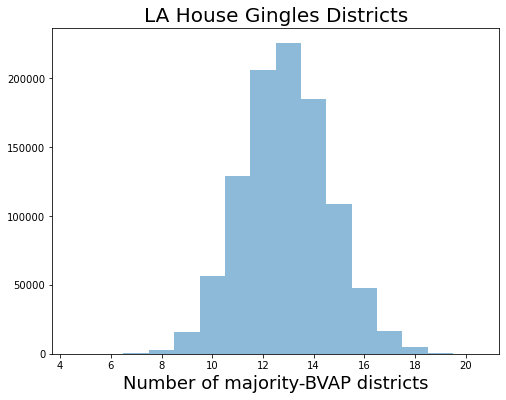

In [225]:
plt.figure(figsize=(8,6))
plt.hist(majority_bvap_dists, bins=np.arange(5,22) - 0.5, alpha=0.5)
plt.title("LA House Gingles Districts", fontsize=20)
plt.xlabel("Number of majority-BVAP districts", fontsize=18)
plt.savefig("plots/unbiased_hist.png", dpi=200, bbox_inches='tight')
plt.show()

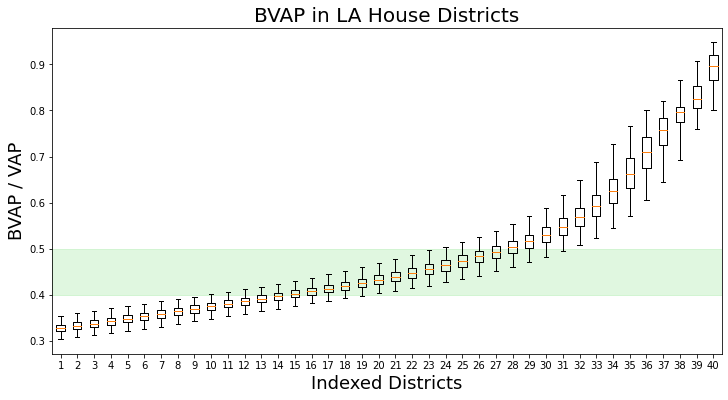

In [224]:
plt.figure(figsize=(12,6))
plt.boxplot(bvap[:,65:], whis=(1,99), showfliers=False)
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
plt.title("BVAP in LA House Districts", fontsize=20)
plt.xlabel("Indexed Districts", fontsize=18)
plt.ylabel("BVAP / VAP", fontsize=18)
plt.savefig("plots/unbiased_boxplot.png", dpi=200, bbox_inches='tight')
plt.show()

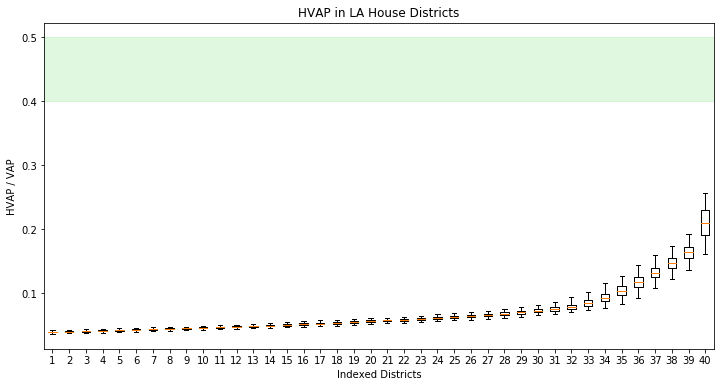

In [12]:
plt.figure(figsize=(12,6))
plt.boxplot(hvap[:,65:], whis=(1,99), showfliers=False)
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
plt.title("HVAP in LA House Districts")
plt.xlabel("Indexed Districts")
plt.ylabel("HVAP / VAP")
plt.show()

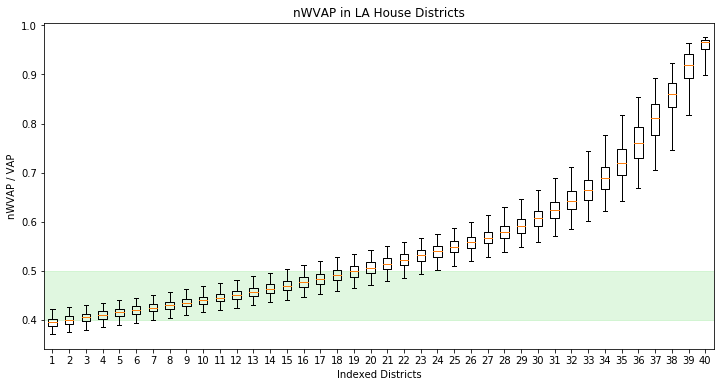

In [13]:
nwvap = 1 - wvap
nwvap = np.flip(nwvap, 1)

plt.figure(figsize=(12,6))
plt.boxplot(nwvap[:,65:], whis=(1,99), showfliers=False)
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
plt.title("nWVAP in LA House Districts")
plt.xlabel("Indexed Districts")
plt.ylabel("nWVAP / VAP")
plt.show()

## Short Burst / Biased Run Results

### Distributions of observed values and observed values vs. steps

In [85]:
min(la_runs_bvap["200"][2])

9.0

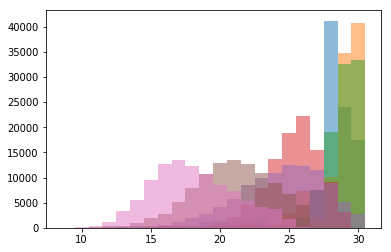

In [86]:
plt.hist(la_runs_bvap["2"][2], bins=np.arange(9,32) - 0.5, alpha=0.5)
plt.hist(la_runs_bvap["5"][2], bins=np.arange(9,32) - 0.5, alpha=0.5)
plt.hist(la_runs_bvap["10"][2], bins=np.arange(9,32) - 0.5, alpha=0.5)
plt.hist(la_runs_bvap["25"][2], bins=np.arange(9,32) - 0.5, alpha=0.5)
plt.hist(la_runs_bvap["50"][2], bins=np.arange(9,32) - 0.5, alpha=0.5)
plt.hist(la_runs_bvap["100"][2], bins=np.arange(9,32) - 0.5, alpha=0.5)
plt.hist(la_runs_bvap["200"][2], bins=np.arange(9,32) - 0.5, alpha=0.5)
plt.show()

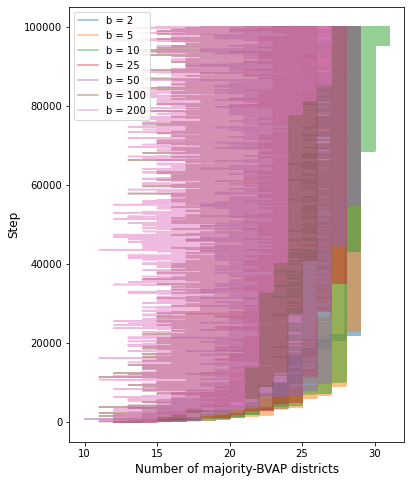

In [219]:
plt.figure(figsize=(6,8))
plt.xlabel("Number of majority-BVAP districts", fontsize=12)
plt.ylabel("Step", fontsize=12)
for b in [2,5,10,25,50,100,200]:
    plt.plot(la_runs_bvap[str(b)][2],range(100000),alpha=0.5, label="b = {}".format(b))
plt.legend(fontsize=10)
plt.savefig("plots/sb_stepwise.png", dpi=200, bbox_inches='tight')
plt.show()

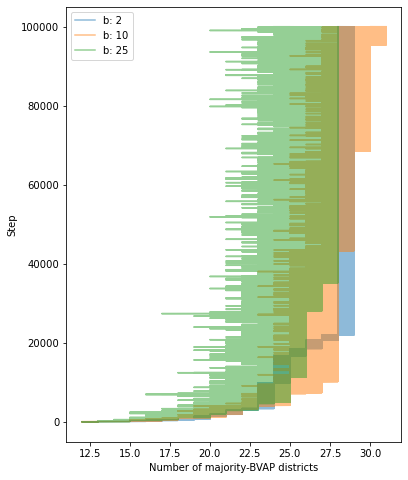

In [16]:
plt.figure(figsize=(6,8))
plt.xlabel("Number of majority-BVAP districts")
plt.ylabel("Step")
for b in [2,10, 25]:
    plt.plot(la_runs_bvap[str(b)][2],range(100000),alpha=0.5, label="b: {}".format(b))
plt.legend()    
plt.show()

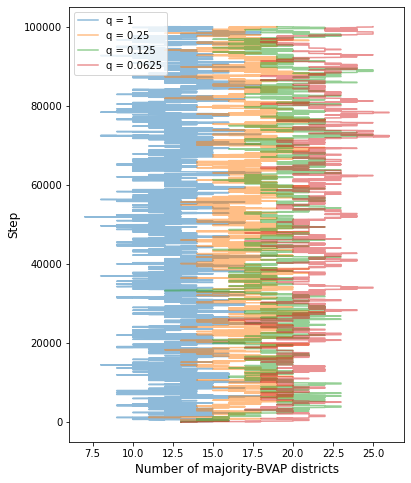

In [49]:
plt.figure(figsize=(6,8))
plt.xlabel("Number of majority-BVAP districts", fontsize=12)
plt.ylabel("Step", fontsize=12)
plt.plot(list(map(lambda p: np.sum(p > 0.5), runs[2]["BVAP"])),
         range(100000),alpha=0.5, label="q = 1".format(p))
for p in [0.25, 0.125, 0.0625]:
    plt.plot(la_runs_bvap[str(p)][2],range(100000),alpha=0.5, label="q = {}".format(p))
plt.legend(loc="upper left",fontsize=10)  
plt.savefig("plots/biased_runs_stepwise.png", dpi=200, bbox_inches='tight')
plt.show()

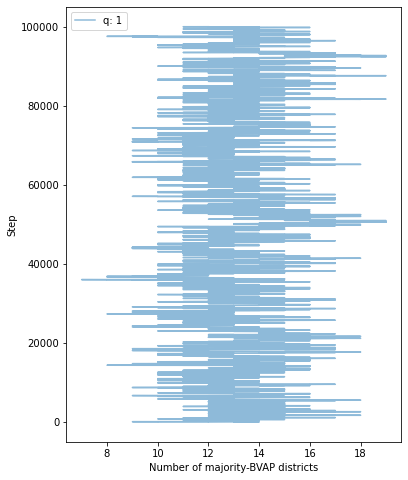

In [30]:
plt.figure(figsize=(6,8))
plt.xlabel("Number of majority-BVAP districts")
plt.ylabel("Step")
plt.plot(list(map(lambda p: np.sum(p > 0.5), runs[0]["BVAP"])),
         range(100000),alpha=0.5, label="q: 1".format(p))
plt.legend(loc="upper left")  

### Expected maximum vs. steps

In [180]:
cmap_no_light = sns.color_palette(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', 
                                   '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
                                   '#808000', '#008080', '#9a6324', '#800000', 
                                   '#aaffc3', '#000075'], n_colors=11)

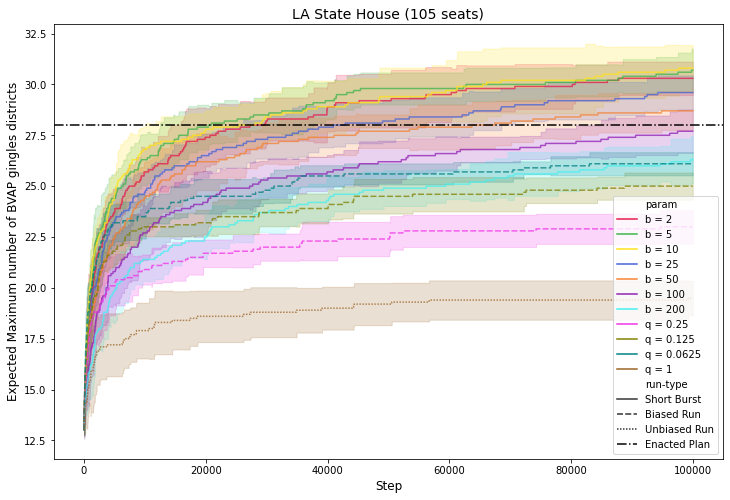

In [234]:
plt.figure(figsize=(12,8))

plt.title("LA State House (105 seats)",fontsize=14)

enacted = 28 # check number

sns.lineplot(x="Step", y="Maximum", hue="param",style="run-type", palette=cmap_no_light,
             data=df_LA_bvap, ci="sd", estimator='mean', alpha=0.75)
plt.axhline(enacted, label="Enacted Plan", c="k", linestyle='dashdot')

plt.ylabel("Expected Maximum number of BVAP gingles districts",fontsize=12)
plt.xlabel("Step",fontsize=12)
plt.legend()
plt.savefig("plots/LA_maxes_all_BVAP.png", dpi=200, bbox_inches='tight')

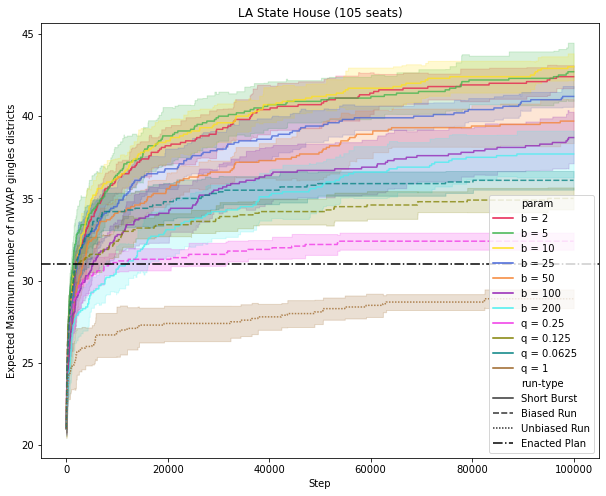

In [235]:
# (col, data, en) = ("nWVAP",df_LA_nwvap, 31)

plt.figure(figsize=(10,8))

plt.title("LA State House (105 seats)")

enacted = 31 # check number

sns.lineplot(x="Step", y="Maximum", hue="param", style="run-type", palette=cmap_no_light,
             data=df_LA_nwvap, ci="sd", estimator='mean', alpha=0.75)
plt.axhline(enacted, label="Enacted Plan", c="k", linestyle='dashdot')
plt.ylabel("Expected Maximum number of nWVAP gingles districts")
plt.legend()
plt.savefig("plots/LA_maxes_all_nWVAP.png", dpi=200, bbox_inches='tight')

## Scratch

In [2]:
cmap = sns.color_palette(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', 
                           '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
                           '#bcf60c', '#fabebe', '#008080', '#e6beff', 
                           '#9a6324', '#fffac8',  '#800000', '#aaffc3', 
                           '#808000', '#ffd8b1', '#000075'])

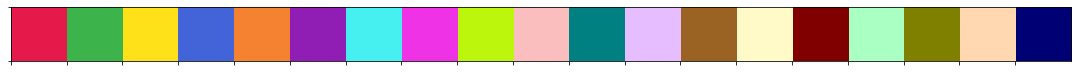

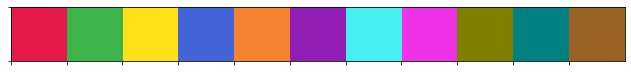

In [181]:
sns.palplot(cmap)
sns.palplot(cmap_no_light)